In [1]:
# 4 cs of data cleaning: collecting, correcting, completing, converting
import pandas as pd
import numpy as np
import datetime 
import yfinance as yf
import warnings
import pickle 
from scipy.stats import mstats

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

equity_df = pd.read_csv("C:/Users/lbianculli/dev/us_equities/ML_categorization/all_fundamentals.csv").drop(
    ["Unnamed: 0", "Unnamed: 0.1", "1mo_fwd_rets"], axis=1)
equity_df["date"] = equity_df["date_dt_x"].astype(str)
equity_df["date_dt"] = pd.to_datetime(equity_df["date"], format='%Y-%m-%d')

# make this more explicit* Dropped because they show as NaNs
equity_df = equity_df.drop(["average_assets", "average_equity", "invested_capital_average", "return_on_average_assets", 
                            "return_on_average_equity", "return_on_invested_capital", "return_on_sales"], axis=1)


## Setup additional Data points
Before we clean the data at the level of the entire dataset, there are some other metrics that come to mind that may be useful in evaluating the performance of a company. For example, some measures that are not already included are leverage, asset turnover, etc. Additionally, metrics based on "average" calculations were returning NaNs, so we will recalculate those (ROE, ROA for example)

In [2]:
# basic calcs
equity_df["buyback_yield"] = -equity_df["issuance_purchase_of_equity_shares"] / equity_df["market_capitalization"]
equity_df["total_yield"] = equity_df["buyback_yield"] + equity_df["dividend_yield"]
equity_df["leverage"] = equity_df["total_assets"] / equity_df["shareholders_equity"]
equity_df["roe"] = equity_df['earnings_before_interest_taxes_depreciation_amortization_ebitda'] / equity_df["avg_equity"]
equity_df["roa"] = equity_df['earnings_before_interest_taxes_depreciation_amortization_ebitda'] / equity_df["avg_assets"]
equity_df["asset_turnover"] = equity_df["revenues_usd"] / equity_df["avg_assets"]
equity_df["debt_to_assets"] = equity_df["total_debt"] / equity_df["avg_assets"]

# Other factors of interest
equity_df["intangibles_to_assets"] = equity_df["goodwill_and_intangible_assets"] / equity_df["total_assets"]
equity_df["rnd_to_revenue"] = equity_df["research_and_development_expense"] / equity_df["revenues_usd"]
equity_df["rnd_to_revenue"] = equity_df["rnd_to_revenue"].replace(np.nan, 0.0)
equity_df["fcf_to_debt"] = equity_df["free_cash_flow"] / equity_df["total_debt"]
equity_df["interest_coverage"] =  equity_df["earning_before_interest_taxes_ebit"] / equity_df["interest_expense"]
equity_df["wc_turnover"] =  equity_df["revenues_usd"] / equity_df["avg_wc"]
equity_df["roc"] =  equity_df["earning_before_interest_taxes_ebit"] / equity_df["avg_capital"]


# DO THIS AFTER exploring data
equity_df = equity_df.replace(np.inf, np.nan)
equity_df = equity_df.replace(-np.inf, np.nan)

In [3]:
# Keep only the columns we need going forward
columns_to_keep = ["period_x", 'date_dt', 'ticker_x', 'id', "sicsector", 'volatility', '1mo_rets', '1mo_log_rets', 
                   '1mo_fwd_log_rets',
                   "accumulated_other_comprehensive_income", "total_assets", "current_assets", "assets_non-current",
                   "asset_turnover", "book_value_per_share", "capital_expenditure", "cash_and_equivalents", 
                   "cost_of_revenue", "consolidated_income", "current_ratio",
                   "debt_to_equity_ratio", "total_debt", "debt_current", "debt_non-current",  
                   "deferred_revenue", "depreciation_amortization_accretion", "deposit_liabilities", "dividend_yield", 
                   "dividends_per_basic_common_share", "earning_before_interest_taxes_ebit", 
                   "earnings_before_interest_taxes_depreciation_amortization_ebitda", "ebitda_margin",
                   "earnings_before_tax", "earnings_per_basic_share", "earnings_per_diluted_share", 
                   "enterprise_value", "enterprise_value_over_ebit", "enterprise_value_over_ebitda", "free_cash_flow", 
                   "free_cash_flow_per_share","gross_profit", "gross_margin", "wc_turnover", 
                   "goodwill_and_intangible_assets", "interest_expense", "invested_capital", "inventory", "investments",
                   "investments_current", "investments_non-current", "total_liabilities", "current_liabilities", 
                   "liabilities_non-current", "net_cash_flow_/_change_in_cash_cash_equivalents", 
                   "net_cash_flow_-_business_acquisitions_and_disposals", "issuance_purchase_of_equity_shares",
                   "issuance_repayment_of_debt_securities_", "payment_of_dividends_other_cash_distributions___", 
                   "net_cash_flow_from_financing", "net_cash_flow_from_investing", "roc", 
                   "net_cash_flow_-_investment_acquisitions_and_disposals", "net_cash_flow_from_operations", 
                   "effect_of_exchange_rate_changes_on_cash_", "net_income", "net_income_common_stock", 
                   "net_loss_income_from_discontinued_operations", "fcf_to_debt", "interest_coverage", 
                   "net_income_to_non-controlling_interests", "profit_margin", "operating_expenses", "operating_income", 
                   "trade_and_non-trade_payables", "payout_ratio", "price_to_book_value", "price_earnings_damodaran_method",
                   "price_to_earnings_ratio", "property_plant_equipment_net", "preferred_dividends_income_statement_impact",
                   "price_sales_damodaran_method", "price_to_sales_ratio", "cfo_std",
                   "trade_and_non-trade_receivables", "accumulated_retained_earnings_deficit", "revenues", 
                   "research_and_development_expense", "share_based_compensation", 
                   "selling_general_and_administrative_expense", "weighted_average_shares", "weighted_average_shares_diluted", "sales_per_share", 
                   "tangible_asset_value", "tax_assets", "income_tax_expense", "tax_liabilities", 
                   "tangible_assets_book_value_per_share", "working_capital", "capex_std","earnings_std", 
                   "buyback_yield", "total_yield", "leverage", "roe", "roa", "debt_to_assets", "tp", "tp_last_yr", 
                   "intangibles_to_assets", "rnd_to_revenue", "market_capitalization", "fwd_fcf_per_share"]

equity_df = equity_df[columns_to_keep]

# rename some columns
equity_df.columns = ["period", 'date_dt', 'ticker', 'id', "sector", 'volatility', '1mo_rets', '1mo_log_rets', 
                     '1mo_fwd_log_rets',
                   "other_comprehensive_income", "total_assets", "current_assets", "non_current_assets",
                   "asset_turnover", "book_value_per_share", "capital_expenditure", "cash_and_equivalents", 
                   "cost_of_revenue", "consolidated_income", "current_ratio",
                   "debt_to_equity", "total_debt", "debt_current", "debt_non-current",  
                   "deferred_revenue", "depreciation_amortization_accretion", "deposit_liabilities", "dividend_yield", 
                   "dividends_per_basic_common_share", "ebit", "wc_turnover", 
                   "earnings_before_interest_taxes_depreciation_amortization_ebitda", "ebitda_margin",
                   "earnings_before_tax", "earnings_per_basic_share", "earnings_per_diluted_share", 
                   "ev", "ev_to_ebit", "ev_to_ebitda", "free_cash_flow", "roc", 
                   "fcf_per_share","gross_profit", "gross_margin", "interest_coverage", 
                   "goodwill_and_intangible_assets", "interest_expense", "invested_capital", "inventory", "investments",
                   "investments_current", "investments_non-current", "total_liabilities", "current_liabilities", 
                   "liabilities_non-current", "net_cash_flow", 
                   "business_acquisitions_and_disposals", "issuance_purchase_of_equity_shares",
                   "issuance_repayment_of_debt_securities_", "payment_of_dividends_other_cash_distributions", 
                   "net_cash_flow_from_financing", "net_cash_flow_from_investing",
                   "net_cf_investment_acquisitions_and_disposals", "net_cash_flow_from_operations", 
                   "effect_of_exchange_rate_changes_on_cash_", "net_income", "net_income_common_stock", 
                   "netincome_from_discontinued_operations", "cfo_std", "fcf_to_debt", 
                   "net_income_to_non-controlling_interests", "profit_margin", "operating_expenses", "operating_income", 
                   "trade_and_non-trade_payables", "payout_ratio", "price_to_book_value", "price_earnings_damodaran_method",
                   "price_to_earnings_ratio", "property_plant_equipment_net", "preferred_dividends_income_statement_impact",
                   "price_sales_damodaran_method", "price_to_sales_ratio", 
                   "trade_and_non-trade_receivables", "accumulated_retained_earnings_deficit", "revenue", 
                   "research_and_development_expense", "share_based_compensation", 
                   "sga_expense", "weighted_average_shares", "weighted_average_shares_diluted", "sales_per_share", 
                   "tangible_asset_value", "tax_assets", "income_tax_expense", "tax_liabilities",
                   "tangible_assets_book_value_per_share", "working_capital", "capex_std","earnings_std", "buyback_yield", 
                   "total_yield", "leverage", "roe", "roa", "debt_to_assets", "tp", "tp_last_yr", 
                    "intangibles_to_assets", "rnd_to_revenue", "market_cap", "fwd_fcf_per_share"]

### Exploratory Data Analysis
The purpose of this EDA is to find insights which will serve us later in another notebook for Data cleaning/preparation/transformation which will ultimately be used into a machine learning algorithm. Data Exploration includes visualizing, finding missing values, imputations, and finding correlations

*** should this be done before or after: scaling, removing outliers, 

In [4]:
import plotly.graph_objects as go
import plotly.express as px

equity_df.describe()

volatility      1mo_rets  1mo_log_rets  1mo_fwd_log_rets  \
count  46003.000000  46003.000000  46003.000000      46003.000000   
mean       0.026101      0.010984     -0.008274          0.005340   
std        0.021738      1.422544      0.157506          0.175447   
min        0.002370     -0.987680     -4.396569         -5.838868   
25%        0.014123     -0.043605     -0.044584         -0.039841   
50%        0.019916      0.005356      0.005341          0.016394   
75%        0.030184      0.051451      0.050171          0.069216   
max        0.507216    268.975031      5.598329          4.618400   

       other_comprehensive_income  total_assets  current_assets  \
count                4.521700e+04  4.521300e+04    3.754700e+04   
mean                -1.583882e+09  1.095655e+11    3.731434e+10   
std                  4.595708e+10  1.532233e+12    6.230905e+11   
min                 -1.804147e+12  1.733461e+07    2.510910e+05   
25%                 -2.362000e+08  4.323401e+09    1.176120e+09   
50%                 -1.423100e+07  1.126200e+10    2.673000e+09   
75%                  8.000000e+05  3.001660e+10    6.160500e+09   
max                  1.639482e+12  5.648380e+13    2.106375e+13   

       non_current_assets  asset_turnover  book_value_per_share  ...  \
count        3.754500e+04    45792.000000          45144.000000  ...   
mean         6.628623e+10        0.192938             41.847921  ...   
std          1.051978e+12        0.191571            388.417903  ...   
min         -3.052200e+07       -1.118180           -537.074000  ...   
25%          1.951227e+09        0.069784              5.924000  ...   
50%          5.745497e+09        0.142471             12.481000  ...   
75%          1.691000e+10        0.254351             24.699750  ...   
max          3.547388e+13        3.187707          15043.876000  ...   

           leverage           roe           roa  debt_to_assets            tp  \
count  45202.000000  45712.000000  45712.000000    45219.000000  46003.000000   
mean       4.181515      0.154344      0.030550        0.280473      0.399474   
std       96.215726      7.093887      0.046007        0.210648      0.489796   
min    -7159.071001   -260.842105     -4.365499        0.000000      0.000000   
25%        1.856240      0.043254      0.015037        0.122713      0.000000   
50%        2.590154      0.078002      0.029184        0.258975      0.000000   
75%        4.095253      0.120568      0.046109        0.397912      1.000000   
max    15285.428571   1159.000000      0.673283        3.881930      1.000000   

         tp_last_yr  intangibles_to_assets  rnd_to_revenue    market_cap  \
count  46003.000000           45213.000000    45948.000000  4.494600e+04   
mean       4.865661               0.190255        1.388545  2.677198e+10   
std        1.608676               0.213359      153.828648  5.915469e+10   
min        0.000000               0.000000       -4.918273  1.761526e+07   
25%        4.000000               0.009464        0.000000  5.266547e+09   
50%        5.000000               0.102159        0.000000  1.088430e+10   
75%        6.000000               0.323397        0.033423  2.391434e+10   
max       11.000000               0.935551    31684.333333  1.920273e+12   

       fwd_fcf_per_share  
count       46003.000000  
mean            0.679110  
std            27.295396  
min         -2906.783000  
25%             0.009000  
50%             0.411000  
75%             1.094000  
max          1622.744000  

[8 rows x 107 columns]

First of all, we will review the number of missing values (NaNs) within each feature of our dataset

In [5]:
# Missing value summary
nan_columns = []
nan_values = []
high_null_cols = []
nan_threshold = 0.1

for column in equity_df.columns:
    nan_columns.append(column)
    total_nans = equity_df[column].isnull().sum()
    nan_values.append(total_nans)
    
    if total_nans / equity_df.shape[0] > nan_threshold:
        high_null_cols.append(column)
        print(f"{total_nans / equity_df.shape[0]*100:.0f}% null values in {column}")

# add ticker, sector so we can explore later
high_null_cols.append("ticker")
high_null_cols.append("sector")

        
fig = go.Figure(go.Bar(
            x=nan_columns,
            y=nan_values,
            orientation='v'))

fig.update_layout(
    title='Missing Values in Fundamental Data',
    xaxis_title="Feature Name",
    yaxis_title="Number of NaNs"
)

fig.show()

18% null values in current_assets
18% null values in non_current_assets
19% null values in current_ratio
18% null values in debt_current
19% null values in debt_non-current
16% null values in gross_profit
18% null values in inventory
18% null values in investments
19% null values in investments_non-current
19% null values in total_liabilities
18% null values in cfo_std
25% null values in weighted_average_shares_diluted
19% null values in working_capital


As we can see, there are a lot of null values in the dataset, with some features being worse offenders than others. We are going to dive deeper into the features where more than 10% of values are null.

Lets take a look at the biggest offenders

In [6]:
high_null_data = equity_df[high_null_cols]
high_null_data.head()

current_assets  non_current_assets  current_ratio  debt_current  \
0    8.382685e+09        1.068316e+09         14.973       10000.0   
1    9.001071e+09        1.270742e+09         12.076           0.0   
2    9.555957e+09        1.738913e+09          9.751           0.0   
3    1.105811e+10        3.337899e+09         11.313           0.0   
4    1.185824e+10        3.834989e+09          9.751           0.0   

   debt_non-current  gross_profit     inventory   investments  \
0               0.0      0.032997  2.111578e+09  0.000000e+00   
1               0.0      0.238715  4.157073e+09  1.436900e+07   
2               0.0      0.267800  5.493849e+09  0.000000e+00   
3               0.0      0.263284  5.805710e+09  1.018591e+09   
4               0.0      0.259585  7.390374e+09  1.028591e+09   

   investments_non-current  total_liabilities  cfo_std  \
0             5.598480e+08         98085000.0      NaN   
1             7.453840e+08        107472000.0      NaN   
2             9.800240e+08         71578000.0      NaN   
3             9.774300e+08         61568000.0      NaN   
4             1.216047e+09         80098000.0      NaN   

   weighted_average_shares_diluted  working_capital ticker    sector  
0                      579346000.0     7.822837e+09  GOOGL  Services  
1                      607946000.0     8.255687e+09  GOOGL  Services  
2                      608246000.0     8.575933e+09  GOOGL  Services  
3                      620076000.0     1.008068e+10  GOOGL  Services  
4                      621148000.0     1.064220e+10  GOOGL  Services

In [7]:
# groupby to find companies/sectors with highest amount of nulls
nulls = high_null_data.loc[high_null_data["weighted_average_shares_diluted"].isnull()]
company_nulls = nulls.groupby("ticker").count().rsub(nulls.groupby("ticker").size(), axis=0)
sector_nulls = nulls.groupby("sector").count().rsub(nulls.groupby("sector").size(), axis=0)

company_nulls.sort_values("weighted_average_shares_diluted", ascending=False)[["weighted_average_shares_diluted"]][:10].style.background_gradient(cmap="Oranges")

since weighted average shares should not be that important (we already have market cap anyway), we will just drop this from the dataset. Then lets examine some other features

In [8]:
equity_df = equity_df.drop(["weighted_average_shares_diluted"], axis=1)

In [9]:
company_nulls.sort_values("current_assets", ascending=False)[["current_assets"]][:10].style.background_gradient(cmap="Oranges")

In [10]:
company_nulls.sort_values("gross_profit", ascending=False)[["gross_profit"]][:10].style.background_gradient(cmap="Oranges")

It looks like the top offenders are consistent across all the features that have significant nans. Let's just drop them so we can ensure higher quality data *

In [11]:
tmp = company_nulls.sort_values("total_liabilities", ascending=False)[["total_liabilities"]][:10].style.background_gradient(cmap="Oranges")
equity_df = equity_df.loc[~equity_df["ticker"].isin(tmp.index)]
equity_df = equity_df.dropna(subset=equity_df.columns[:5])

I think the rest of the columns are relatively important, even if a bit redundant. So we are going to impute values for these null entries. Popular methods for imputation include using the mean, median, or mode. However, we are going to use the KNN Imputer

In [12]:
from sklearn.impute import KNNImputer

# instantiate imputer and transform the dataset
knn_imputer = KNNImputer(n_neighbors=5)

# make sure to reset indexes so we can re-align after
equity_df_imputed = knn_imputer.fit_transform(equity_df[equity_df.columns[5:]])
equity_df = equity_df.reset_index(drop=True)

# create DF and merge
equity_df_imputed = pd.DataFrame(equity_df_imputed, columns=equity_df.columns[5:])
equity_df_imputed = pd.concat([equity_df[equity_df.columns[:5]].reset_index(drop=True), equity_df_imputed], axis=1)

assert(equity_df_imputed.shape == equity_df_imputed.dropna().shape)

equity_df_imputed.tail()

period    date_dt ticker           id  \
45032   2021-3 2021-03-31    OGS   OGS-2021-3   
45033   2018-9 2018-09-28    OGS   OGS-2018-9   
45034  2018-12 2018-12-31    OGS  OGS-2018-12   
45035   2019-3 2019-03-29    OGS   OGS-2019-3   
45036   2019-6 2019-06-28    OGS   OGS-2019-6   

                                                  sector  volatility  \
45032  Transportation Communications Electric Gas And...    0.021613   
45033  Transportation Communications Electric Gas And...    0.018233   
45034  Transportation Communications Electric Gas And...    0.016722   
45035  Transportation Communications Electric Gas And...    0.015585   
45036  Transportation Communications Electric Gas And...    0.015048   

       1mo_rets  1mo_log_rets  1mo_fwd_log_rets  other_comprehensive_income  \
45032  0.118203      0.111723          0.045248                  -7477000.0   
45033  0.201586      0.183642         -0.012843                  -5167000.0   
45034 -0.047847     -0.049030          0.031533                  -4086000.0   
45035  0.029844      0.029407         -0.005745                  -5144000.0   
45036  0.046229      0.045192          0.015385                  -4984000.0   

       ...  leverage       roe       roa  debt_to_assets   tp  tp_last_yr  \
45032  ...  3.779460  0.088272  0.027186        0.615919  1.0         4.0   
45033  ...  2.555239  0.040471  0.015576        0.258256  0.0         2.0   
45034  ...  2.677221  0.064540  0.024665        0.298445  1.0         2.0   
45035  ...  2.624641  0.090696  0.034218        0.287655  0.0         1.0   
45036  ...  2.583212  0.050140  0.019255        0.287818  0.0         2.0   

       intangibles_to_assets  rnd_to_revenue    market_cap  fwd_fcf_per_share  
45032               0.018198             0.0  4.094995e+09             -0.674  
45033               0.030653             0.0  4.321161e+09             -1.596  
45034               0.028883             0.0  4.181097e+09              0.738  
45035               0.028592             0.0  4.680598e+09              0.337  
45036               0.029000             0.0  4.757603e+09             -1.399  

[5 rows x 111 columns]

### Handling outliers

We will be using DBSCAN for outlier detection and removal. This algorithm works by clustering points based on two hyperparameters: the distance other points must be to be included in the cluster (epsilon) and the minimum number of points necessary to form a cluster

This will start by determining the best value for eps (the observation distance threashold) using the approach explained in https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc



For more on DBSCAN: https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80

In [13]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

scaled_data = equity_df_imputed.copy()
cols_to_scale = equity_df_imputed.columns[5:]
scaler = StandardScaler().fit_transform(scaled_data[cols_to_scale].values)

In [14]:
# start with neighbors algorithm on our scaled data
neigh = NearestNeighbors(n_neighbors=2)  # find distances between every point and closest neighbor
nbrs = neigh.fit(scaler)
distances, indices = nbrs.kneighbors(scaler)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [15]:
# plot
fig = px.scatter(
    distances, 
    title='Distance Curve')
fig.update_xaxes(title_text='Distances')
fig.update_yaxes(title_text='Distance threshold (epsilon)')
fig.show()

The optimal value for epsilon will be found at the point on the curve where acceleration begins to pickup (the elbow). It looks like the optimal value is about 6. The minimum points hyperparameter is also a bit subjective, but for large datasets a good rule of thumb is to set it equal to the number of features, so thats what we will do

In [16]:
# run DBSCAN given eps and min points (should be 5-6 eps)
db = DBSCAN(eps=4, min_samples=scaled_data.shape[1]).fit(scaler)

labels = db.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Number of clusters in labels, ignoring noise
n_noise = list(labels).count(-1)
n_clusters = len(set(labels)) - 1

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")
print(f"Silhouette Coefficient: {metrics.silhouette_score(scaler, labels):.3f}")  # what is this?

print(f"Outliers removed: {equity_df_imputed.shape[0] - equity_df_imputed.loc[labels != -1].shape[0]}\n")
equity_df_clean = equity_df_imputed.loc[labels != -1]

Estimated number of clusters: 2
Estimated number of noise points: 2240
Silhouette Coefficient: 0.715
Outliers removed: 2240



The Silhouette score is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample. The Silhouette coefficient for a sample is (b - a) / max(a, b). Silhouette coefficients measure the goodness of the clustering technique and range from -1 to 1, with 1 being the best (i.e. the clusters are clearly distinguihsed from each other). 

It looks like the DBSCAN managed to cluster the points quite well, with a Silhouette score > .7!

# Data Visualzations

We have more or less finalized our dataset (prior to the premodeling phase). Before we move on, it would be useful to put together some visualizations that assist in giving a more intuitive picture into the nature of our currated dataset. Some of the visualizations we will explore include:

- distribution of target variables
- correlation heatmap of features
- feature distributions according to market cap segment

In [17]:
import seaborn as sns
sns.set()

# find correlation of features with the target
corrs = equity_df_clean.corrwith(equity_df_clean["fwd_fcf_per_share"])
corrs = abs(corrs)

# get top correlated variables for stat analysis and visualizations
top_corrs = list(corrs.sort_values(ascending=False).index)

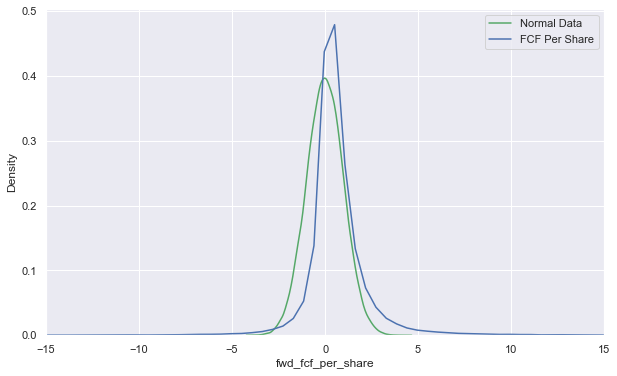

In [18]:
# filter data on top-correlated variables and plot hists
top_corr_data = equity_df_clean[top_corrs]
log_labels = equity_df_clean["fwd_fcf_per_share"].apply(lambda x: np.log(x+1))  # **

# get synthetic normal data
normal_data = np.random.normal(size=top_corr_data.shape[0])

# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlim([-15, 15])

sns.kdeplot(normal_data, ax=ax, label='Normal Data', color="g")
sns.kdeplot(equity_df_clean["fwd_fcf_per_share"], ax=ax, label='FCF Per Share')
plt.legend();

We can see that our data has significant positive skew

Lets now take a look at how correlated the top features are with each other with the help of a Seaborn heatmap

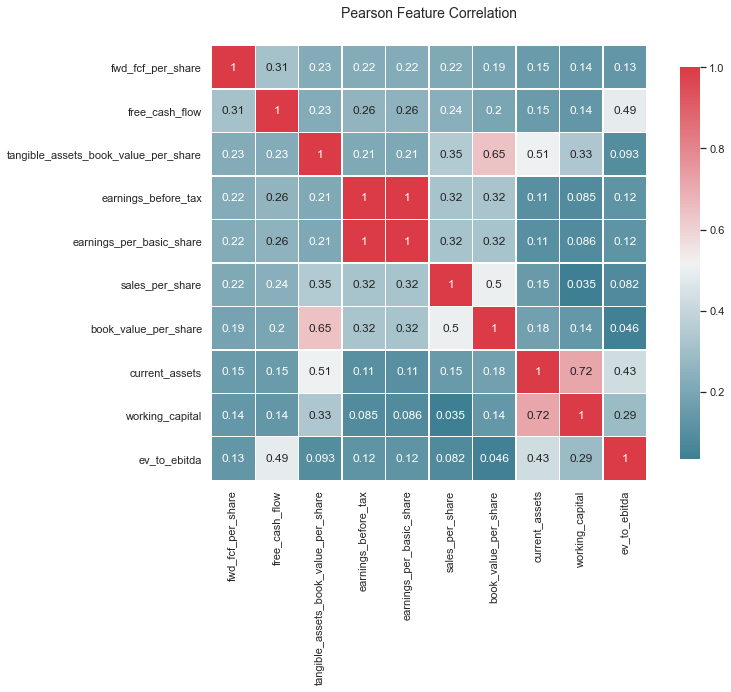

In [19]:
def corr_heatmap(df, n_vars=10):
    """ plot correlation heatmap of variables in a given pandas DataFrame """
    df = df[df.columns[:n_vars]]
    _, ax = plt.subplots(figsize=(12, 8))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    _ = sns.heatmap(df.corr(), 
                    cmap=colormap, 
                    square=True, 
                    cbar_kws={"shrink": 0.9}, 
                    ax=ax, 
                    annot=True, 
                    linewidths=0.1,
                    vmax=1.0,
                    linecolor="white",
                    annot_kws={"fontsize": 12}
                   )
    
    plt.title("Pearson Feature Correlation", y=1.05, size=14)
    
corr_heatmap(top_corr_data, 10)

Now let's take a look at a slightly different heatmap. The above visualization shows the correlation of high-correlated variables with each other. The next will display correlations with the target

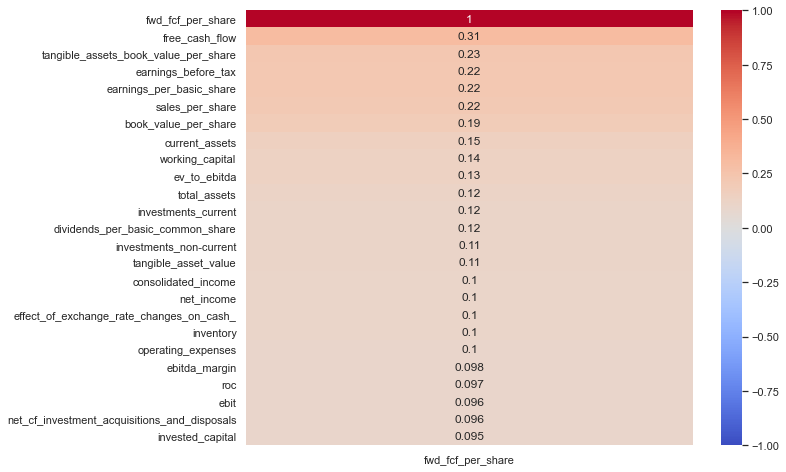

In [20]:
def heatmap_numeric_w_dependent_variable(df, dependent_variable, n_vars=10):
    """
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    """
    if n_vars > 30:
        plt.figure(figsize=(10, 10))
    else: 
        plt.figure(figsize=(10, 8))
    
    corr_data = abs(df.corr()[[dependent_variable]])
    corr_data = corr_data.sort_values(by=dependent_variable, ascending=False).head(n_vars)

    # create graph object
    g = sns.heatmap(corr_data, 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g

viz = equity_df_clean.copy()
heatmap_numeric_w_dependent_variable(viz, "fwd_fcf_per_share", n_vars=25);

Before moving on from data visualizations, we will put together two additional views. The first will be the distribution of the target variable given the market cap of the company. After that, we will examine a scatter plot of the target based on the highest-correlated variable (EPS), color-coded according to sector.

### KDE Plot

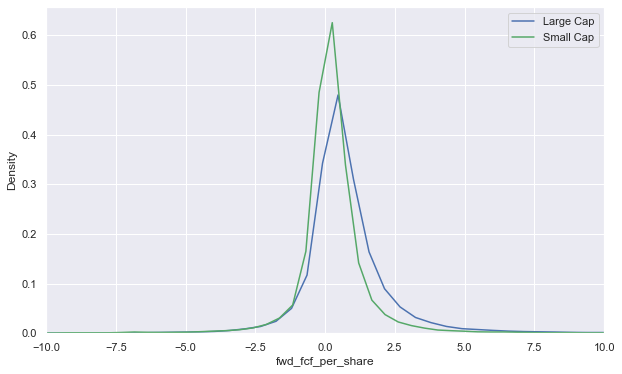

In [21]:
# TODO: Add skew/kurtosis metrics
kde_data = equity_df_clean.copy()
mc_threshold = 5000000000  # set threshold to 1B 

# segregate data
large_cap_data = kde_data.loc[kde_data["market_cap"] > mc_threshold]
small_cap_data = kde_data.loc[kde_data["market_cap"] < mc_threshold]

# plot distributions for different targets
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlim([-10, 10])
sns.kdeplot(large_cap_data["fwd_fcf_per_share"], ax=ax, label='Large Cap', color="b")
sns.kdeplot(small_cap_data["fwd_fcf_per_share"], ax=ax, label='Small Cap', color="g")
plt.legend();

It looks like the distribution of the target for large cap companies is more positively-skewed than for small cap companies. The tails are also fatter, particularly the right tail.

### Scatter Plot

Since there are too many data points to do this without filtering, lets take a look at a scatter plot based on data since 2019

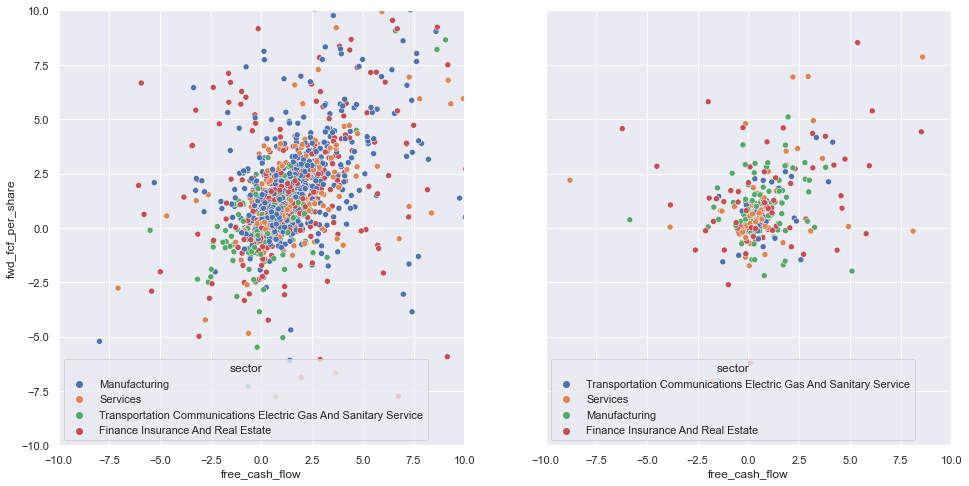

In [22]:
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scatter_data = equity_df_clean.loc[equity_df_clean["date_dt"].dt.year > 2019].copy()

# lets also filter on companies with positive net income
scatter_data = scatter_data.loc[scatter_data["net_income"] > 0]

# get top sectors and split based on market cap
largest_sectors = scatter_data["sector"].value_counts()[:4]
small_cap_data = scatter_data.loc[scatter_data["market_cap"] < mc_threshold]
large_cap_data = scatter_data.loc[scatter_data["market_cap"] > mc_threshold]

small_cap_data = small_cap_data.loc[small_cap_data["sector"].isin(largest_sectors.index)]
large_cap_data = large_cap_data.loc[large_cap_data["sector"].isin(largest_sectors.index)]

small_cap_data = small_cap_data[["sector", "free_cash_flow", "fwd_fcf_per_share"]]
large_cap_data = large_cap_data[["sector", "free_cash_flow", "fwd_fcf_per_share"]]

# create figure and subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16, 8))

# set axis limits
ax1.set_xlim([-10, 10])
ax1.set_ylim([-10, 10])
ax2.set_xlim([-10, 10])
ax2.set_ylim([-10, 10])

sns.scatterplot(data=large_cap_data, x="free_cash_flow", y="fwd_fcf_per_share", hue="sector", ax=ax1);
sns.scatterplot(data=small_cap_data, x="free_cash_flow", y="fwd_fcf_per_share", hue="sector", ax=ax2);


There are a lot of points here, but there are some key points we can take from these charts:
1. There is a clear correlation between the two variables, but it is less clear for some sectors, such as the transportation, comms, gas, and sanitary companies
2. The correlation seems to be much weaker for small cap companies
3. There are very few instances of a company with negative free cash flow and positive free cash flow per share in the next period
4. There still seem to be outliers in our data, even when only looking at two variables

## Standardize Data

The data needs to be standardized in preparation for feeding into the model. This is the final transformation that will be made across the entire dataset. We will simply demeand each datapoint and divide by standard deviation (according to the variable mean and standard deviation)

In [23]:
# now standardize the entire dataset at the sector level
sector_dfs = []

# isolate sector-specific data and perform operations
for sector in equity_df_clean["sector"].unique():
    sector_data = equity_df_clean.loc[equity_df_clean["sector"] == sector]
    tmp = sector_data[["period","date_dt","ticker","id","sector"]]
    sector_data = sector_data.drop(["period","date_dt","ticker","id","sector"], axis=1)
    
    sector_data = (sector_data - sector_data.mean()) / sector_data.std(ddof=1)

    # winsorize
    for c in sector_data.columns:
        sector_data[c] = mstats.winsorize(sector_data[c], limits=[0.05, 0.05])
        
    
    sector_dfs.append(tmp.join(sector_data))
    
# remerge everything and fill nans for those that had 0 for std
normed_equity_df = pd.concat([df for df in sector_dfs], axis=0)
normed_equity_df = normed_equity_df.fillna(normed_equity_df.mean())

## Encode categorical features

Finally, the last step of the preprocessing phase is to encode categorical features. We encode categorical features because qualititative datapoints are not usable by particular ML algorithms. 

The only categorical variable we have is sector. Since this is a non-ordinal variable, we will need to one-hot encode it so that it can be processed correctly by our algorithms later.

For more on one-hot encoding: https://towardsdatascience.com/what-is-one-hot-encoding-and-how-to-use-pandas-get-dummies-function-922eb9bd4970

In [24]:
# one-hot encode the sector names
def one_hot(df, label):
    # get encoded vectors
    one_hots = pd.get_dummies(df[label])
    
    # drop original label and add on one-hot label
    df = df.drop([label], axis=1)
    df = df.join(one_hots)
    
    return df

normed_equity_df_encoded = one_hot(normed_equity_df, "sector")
normed_equity_df_encoded.head()

period    date_dt ticker             id  volatility  1mo_rets  \
1  2005-12 2005-12-30  GOOGL  GOOGL-2005-12   -0.431383  0.219723   
2   2006-3 2006-03-31  GOOGL   GOOGL-2006-3   -0.330752  0.309050   
3   2006-6 2006-06-30  GOOGL   GOOGL-2006-6   -0.346676  0.777943   
4   2006-9 2006-09-29  GOOGL   GOOGL-2006-9   -0.351116  0.461991   
5  2006-12 2006-12-29  GOOGL  GOOGL-2006-12   -0.391474 -0.362540   

   1mo_log_rets  1mo_fwd_log_rets  other_comprehensive_income  total_assets  \
1      0.253564         -0.301533                    0.193945      0.001064   
2      0.328480         -0.002899                    0.158634      0.063685   
3      0.708659         -0.829984                    0.117974      0.253505   
4      0.454851          1.064159                    0.195033      0.332908   
5     -0.256234          0.219199                    0.241311      0.503079   

   ...  fwd_fcf_per_share  Agriculture Forestry And Fishing  Construction  \
1  ...           0.064668                                 0             0   
2  ...          -0.195605                                 0             0   
3  ...           0.077212                                 0             0   
4  ...          -0.197397                                 0             0   
5  ...           0.147544                                 0             0   

   Finance Insurance And Real Estate  Manufacturing  Mining  Retail Trade  \
1                                  0              0       0             0   
2                                  0              0       0             0   
3                                  0              0       0             0   
4                                  0              0       0             0   
5                                  0              0       0             0   

   Services  Transportation Communications Electric Gas And Sanitary Service  \
1         1                                                  0                 
2         1                                                  0                 
3         1                                                  0                 
4         1                                                  0                 
5         1                                                  0                 

   Wholesale Trade  
1                0  
2                0  
3                0  
4                0  
5                0  

[5 rows x 119 columns]

In [25]:
# clean_equity_data.drop(["outlier"], axis=1).dropna().to_csv("C:/Users/lbianculli/dev/us_equities/us_data_final.csv")
normed_equity_df_encoded.to_csv("C:/Users/lbianculli/dev/us_equities/ML_categorization/us_data_final_reg.csv")

normed_equity_df_encoded.shape

(42797, 119)

### premodeling next